<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/American_Call_jax_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
a = []
while(1):
    a.append('1')

# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

## Use (X, Y) = (0, 0) for lstsq

In [1]:
# change from CF matrix to CF array
# put
# r is constant here for testing
# large numpaths & numsteps to test price here
# use normal for loop
# test jnp.where

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths):  
  out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
  out_avg = jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2)

  dt = T / numsteps
  ITM_matrix = out_avg <= K # matrix that is true if ITM, else false
  CF_array = jnp.maximum(K-out_avg[:,-1], 0) # array that will store discounted cash flows for the next time period

  # update t=T-1 to t=0
  for i in range(2, numsteps+1):
    ITM_boolean = ITM_matrix[:,-i]
    print('ITM_boolean')
    print(ITM_boolean)
    X = jnp.where(ITM_boolean, out_avg[:,-i], 0) # if ITM, use out_avg, if not, use nan
    print('X')
    print(X)
    CF_array = (CF_array * jnp.exp(-r * dt)) # discount CF_array by one step
    print('CF_array')
    print(CF_array)
    Y = jnp.where(ITM_boolean, CF_array, 0) # if ITM, Y = CF array, if not, use nan
    print('Y')
    print(Y)
    X_matrix = jnp.array([X**0,X**1,X**2]).transpose()
    print('X_matrix')
    print(X_matrix)

    ECV = X_matrix.dot(jax.numpy.linalg.lstsq(X_matrix, Y, rcond=-1)[0]) # predicted Y - ECV - expected continue value
    ECV = jnp.where(ITM_boolean, ECV, 10000) # replace not ITM ECV by 10000 (so that K-X < ECV)
    print('ECV')
    print(ECV)

    KX_larger_than_ECV = (K-X > ECV)
    CF_array = KX_larger_than_ECV*(K-X) + (1-KX_larger_than_ECV)*CF_array

  return  (CF_array * jnp.exp(-r * dt)).mean() # take mean for all paths to get price

numstocks = 1
numpaths = 5
numsteps = 2

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
drift = jnp.array([0.05]*numstocks)
r = drift # let r = drift to match B-S

cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.]*numstocks) # must be float

T = 1.0
K = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
#fast_simple(key, initial_stocks, numsteps, drift, cov)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

#################################################################################### values for checking
#S, K, r, drift, sigma, T
# 40, 40, 0.06, 0.06, 0.2(1stock) 0.34641016151(3stock), 1
# option price should be around 2.33
# np price: 2.3384

#S, K, r, drift, sigma, T
# 100, 100, 0.01, 0.01, 0.25, 1
# option price should be around 9.51
# np price: 9.5610
####################################################################################

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))
# %timeit(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))

# # delta test
# goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))
# %timeit(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))

ITM_boolean
[ True  True False False  True]
X
[0.9103706  0.80439687 0.         0.         0.78181326]
CF_array
[2.2324497e-01 2.7355844e-01 0.0000000e+00 1.2289317e-04 2.0748040e-01]
Y
[0.22324497 0.27355844 0.         0.         0.2074804 ]
X_matrix
[[1.         0.9103706  0.82877463]
 [1.         0.80439687 0.6470543 ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.78181326 0.611232  ]]
ECV
[2.2884783e-01 2.3746118e-01 1.0000000e+04 1.0000000e+04 2.3809588e-01]
0.13740297


In [ ]:
# change from CF matrix to CF array
# put
# r is constant here for testing
# large numpaths & numsteps to test price here
# use lax.scan
# replace X=0 and Y=0 for OTM
# to run grad in colab, max is 10000 paths

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths):  
  out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
  out_avg = jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2)

  dt = T / numsteps
  ITM_matrix = out_avg <= K # matrix that is true if ITM, else false
  CF_array = jnp.maximum(K-out_avg[:,-1], 0) # array that will store discounted cash flows for the next time period

  def for_loop(numsteps, r, K, dt, ITM_matrix, CF_array):
    def body_fun(val, i):
      ITM_boolean = ITM_matrix[:,-i]
      X = jnp.where(ITM_boolean, out_avg[:,-i], 0) # if ITM, use out_avg, if not, use 0
      val = (val * jnp.exp(-r * dt)) # discount CF_array by one step
      Y = jnp.where(ITM_boolean, val, 0) # if ITM, Y = CF array, if not, use 0
      X_matrix = jnp.array([X**0,X**1,X**2,X**3]).transpose()
      ECV = X_matrix.dot(jax.numpy.linalg.lstsq(X_matrix, Y, rcond=-1)[0]) # predicted Y - ECV - expected continue value
      ECV = jnp.where(ITM_boolean, ECV, 10000) # replace not ITM ECV by 10000 (so that K-X < ECV)

      # update CF_array
      KX_larger_than_ECV = (K-X > ECV)
      val = KX_larger_than_ECV*(K-X) + (1-KX_larger_than_ECV)*val
      return val, i

    counts = jnp.arange(2, numsteps+1)
    CF_array, _ =  jax.lax.scan(body_fun, CF_array, counts)
    return (CF_array * jnp.exp(-r * dt)).mean()

  CF_out = for_loop(numsteps, r.copy()[0], K, dt, ITM_matrix, CF_array)
  return CF_out

numstocks = 1
numpaths = 10000
numsteps = 200

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
drift = jnp.array([0.05]*numstocks)
r = drift # let r = drift to match B-S

cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.]*numstocks) # must be float

T = 1.0
K = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
#fast_simple(key, initial_stocks, numsteps, drift, cov)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

#################################################################################### values for checking
#S, K, r, drift, sigma, T
# 1, 1, 0.05, 0.05, 0.25, 1
# option price should be around 0.079873
# jnp price: 0.079862

#S, K, r, drift, sigma, T
# 100, 80, 0.05, 0.05, 0.3, 1 (more OTM here)
# option price should be around 2.663678
# jnp price: 2.65607
####################################################################################

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))
%timeit(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))
%timeit(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))

0.07941516
1 loop, best of 5: 384 ms per loop
[-0.42788124]
1 loop, best of 5: 769 ms per loop


In [7]:
# change from CF matrix to CF array
# put
# r is constant here for testing
# large numpaths & numsteps to test price here
# use lax.scan
# replace X=0 and Y=0 for OTM
# to run grad in colab, max is 10000 paths

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths):  
  numbatches = 10 # if numbatches is larger, max numpaths can be larger. Note: the larger the numbatches, the longer the computation will take
  out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
  out_avg = jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2)

  dt = T / numsteps
  ITM_matrix = out_avg <= K # matrix that is true if ITM, else false
  CF_array = jnp.maximum(K-out_avg[:,-1], 0) # array that will store discounted cash flows for the next time period

  def for_loop(numsteps, r, K, dt, ITM_matrix, CF_array, numpaths, numbatches):
    def body_fun(val, i):
      ITM_boolean = ITM_matrix[:,-i]
      X = jnp.where(ITM_boolean, out_avg[:,-i], 0) # if ITM, use out_avg, if not, use 0
      val = (val * jnp.exp(-r * dt)) # discount CF_array by one step
      Y = jnp.where(ITM_boolean, val, 0) # if ITM, Y = CF array, if not, use 0
      X_matrix = jnp.array([X**0,X**1,X**2,X**3]).transpose()

      ECV = jnp.zeros(numpaths)
      # i_list = [i for i in range(numbatches)] # have to do this because the subsetting below needs static numbers (i can't be variable)
      # # get list of subsets for all the arrays. Need to convert back to jnp.array or else will give errors inner loop below
      # X_matrix_list = jnp.array([X_matrix[int(numpaths*i/len(i_list)):int(numpaths*(i+1)/len(i_list)),:] for i in i_list])
      # Y_list = jnp.array([Y[int(numpaths*i/len(i_list)):int(numpaths*(i+1)/len(i_list))] for i in i_list])
      # ITM_boolean_list = jnp.array([ITM_boolean[int(numpaths*i/len(i_list)):int(numpaths*(i+1)/len(i_list))] for i in i_list])

      X_matrix_3D = X_matrix.reshape((numbatches, -1, 4))
      Y_3D = Y.reshape((numbatches, -1))
      ITM_boolean_3D = ITM_boolean.reshape((numbatches, -1))

      # inner loop (more batches so that numpaths can be larger without running out of memory)
      def ECV_fun(val_2, i_2):
        ECV_sub = X_matrix_3D[i_2].dot(jax.numpy.linalg.lstsq(X_matrix_3D[i_2], Y_3D[i_2], rcond=-1)[0]) # predicted Y - ECV - expected continue value
        ECV_sub = jnp.where(ITM_boolean_3D[i_2], ECV_sub, 10000) # replace not ITM ECV by 10000 (so that K-X < ECV)
        val_2 = jax.lax.dynamic_update_slice(val_2,
                                             ECV_sub,
                                             ((numpaths*i_2/numbatches).astype(int),)) # update the part for this batch in ECV array
        return val_2, i_2

      counts2 = jnp.arange(numbatches)
      ECV, _ =  jax.lax.scan(ECV_fun, ECV, counts2)

      # update CF_array
      KX_larger_than_ECV = (K-X > ECV)
      val = KX_larger_than_ECV*(K-X) + (1-KX_larger_than_ECV)*val
      return val, i

    counts = jnp.arange(2, numsteps+1)
    CF_array, _ =  jax.lax.scan(body_fun, CF_array, counts)
    return (CF_array * jnp.exp(-r * dt)).mean()

  CF_out = for_loop(numsteps, r.copy()[0], K, dt, ITM_matrix, CF_array, numpaths, numbatches)
  return CF_out

numstocks = 1
numpaths = 100000
numsteps = 200

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
drift = jnp.array([0.05]*numstocks)
r = drift # let r = drift to match B-S

cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.]*numstocks) # must be float

T = 1.0
K = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
#fast_simple(key, initial_stocks, numsteps, drift, cov)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

#################################################################################### values for checking
#S, K, r, drift, sigma, T
# 1, 1, 0.05, 0.05, 0.25, 1
# option price should be around 0.079873
# jnp price: 0.079862

#S, K, r, drift, sigma, T
# 100, 80, 0.05, 0.05, 0.3, 1 (more OTM here)
# option price should be around 2.663678
# jnp price: 2.65607
####################################################################################

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))
# %timeit(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))

# # delta test
# goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))
# %timeit(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T, numpaths))

0.079870075


In [ ]:
pip install option-price

In [ ]:
from optionprice import Option

some_option = Option(european=False,
                    kind='put',
                    s0=1,
                    k=1,
                    sigma=0.25,
                    r=0.05,
                    start='2020-01-01',
                    end='2021-01-01',
                    dv=0)
price = some_option.getPrice(method='BT',iteration = 1000)
price

0.07981892015757565

In [ ]:
def binomial(S, K, sigma, r):
  some_option = Option(european=False,
                    kind='put',
                    s0=S,
                    k=K,
                    sigma=sigma,
                    r=r,
                    start='2020-01-01',
                    end='2021-01-01',
                    dv=0)
  price = some_option.getPrice(method='BT',iteration = 1000)
  return(price)

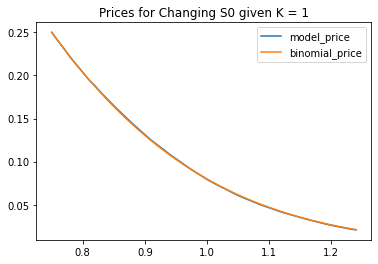

In [ ]:
import matplotlib.pyplot as plt
S = 1
K = 1
sigma = 0.25
r = 0.05
cov = jnp.identity(numstocks)*sigma*sigma
numpaths = 50000

S_list = np.arange(0.75, 1.25, 0.01)
K_list = np.arange(0.75, 1.25, 0.01)
sigma_list = np.arange(0.15, 0.45, 0.005)
r_list = np.arange(0, 0.1, 0.002)

model_price = []
binomial_price = []

for S in S_list:
    model_price.append(optionvalueavg(key, jnp.array([S]), 
                                      numsteps, jnp.array([r]), 
                                      jnp.array([r]), cov, K, T, numpaths))
    binomial_price.append(binomial(S, K, sigma, r))

plt.plot(S_list, model_price, label = "model_price")
plt.plot(S_list, binomial_price, label = "binomial_price")
plt.title('Prices for Changing S0 given K = 1')
plt.legend()
plt.show()

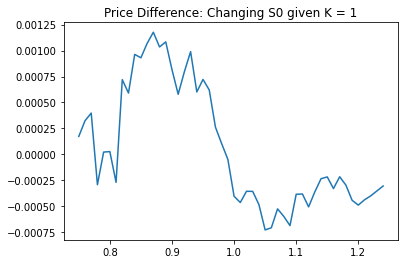

In [ ]:
plt.plot(S_list, np.array(model_price)-np.array(binomial_price))
plt.title('Price Difference: Changing S0 given K = 1')
plt.show()

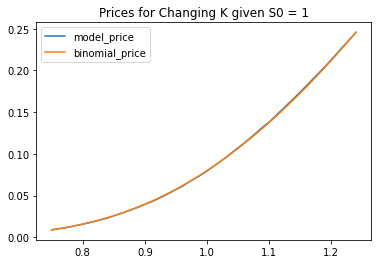

In [ ]:
import matplotlib.pyplot as plt
S = 1
K = 1
sigma = 0.25
r = 0.05
cov = jnp.identity(numstocks)*sigma*sigma
numpaths = 50000

S_list = np.arange(0.75, 1.25, 0.01)
K_list = np.arange(0.75, 1.25, 0.01)
sigma_list = np.arange(0.15, 0.45, 0.005)
r_list = np.arange(0, 0.1, 0.002)

model_price = []
binomial_price = []

for K in K_list:
    model_price.append(optionvalueavg(key, jnp.array([S]), 
                                      numsteps, jnp.array([r]), 
                                      jnp.array([r]), cov, K, T, numpaths))
    binomial_price.append(binomial(S, K, sigma, r))

plt.plot(K_list, model_price, label = "model_price")
plt.plot(K_list, binomial_price, label = "binomial_price")
plt.title('Prices for Changing K given S0 = 1')
plt.legend()
plt.show()

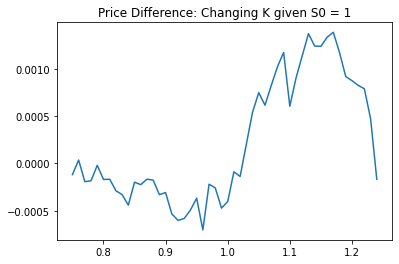

In [ ]:
plt.plot(K_list, np.array(model_price)-np.array(binomial_price))
plt.title('Price Difference: Changing K given S0 = 1')
plt.show()

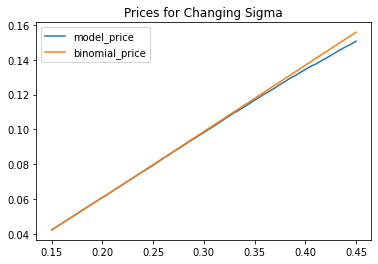

In [ ]:
import matplotlib.pyplot as plt
S = 1
K = 1
sigma = 0.25
r = 0.05
cov = jnp.identity(numstocks)*sigma*sigma
numpaths = 50000

S_list = np.arange(0.75, 1.25, 0.01)
K_list = np.arange(0.75, 1.25, 0.01)
sigma_list = np.arange(0.15, 0.45, 0.005)
r_list = np.arange(0, 0.1, 0.002)

model_price = []
binomial_price = []

for sigma in sigma_list:
    cov = jnp.identity(numstocks)*sigma*sigma
    model_price.append(optionvalueavg(key, jnp.array([S]), 
                                      numsteps, jnp.array([r]), 
                                      jnp.array([r]), cov, K, T, numpaths))
    binomial_price.append(binomial(S, K, sigma, r))

plt.plot(sigma_list, model_price, label = "model_price")
plt.plot(sigma_list, binomial_price, label = "binomial_price")
plt.title('Prices for Changing Sigma')
plt.legend()
plt.show()

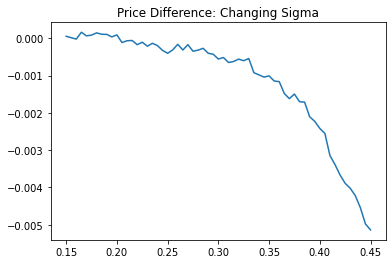

In [ ]:
plt.plot(sigma_list, np.array(model_price)-np.array(binomial_price))
plt.title('Price Difference: Changing Sigma')
plt.show()

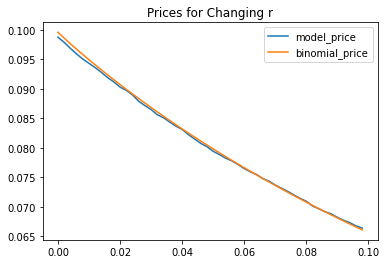

In [ ]:
import matplotlib.pyplot as plt
S = 1
K = 1
sigma = 0.25
r = 0.05
cov = jnp.identity(numstocks)*sigma*sigma
numpaths = 50000

S_list = np.arange(0.75, 1.25, 0.01)
K_list = np.arange(0.75, 1.25, 0.01)
sigma_list = np.arange(0.15, 0.45, 0.005)
r_list = np.arange(0, 0.1, 0.002)

model_price = []
binomial_price = []

for r in r_list:
    model_price.append(optionvalueavg(key, jnp.array([S]), 
                                      numsteps, jnp.array([r]), 
                                      jnp.array([r]), cov, K, T, numpaths))
    binomial_price.append(binomial(S, K, sigma, r))

plt.plot(r_list, model_price, label = "model_price")
plt.plot(r_list, binomial_price, label = "binomial_price")
plt.title('Prices for Changing r')
plt.legend()
plt.show()

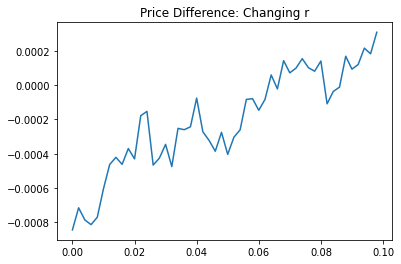

In [ ]:
plt.plot(r_list, np.array(model_price)-np.array(binomial_price))
plt.title('Price Difference: Changing r')
plt.show()

# Construct Neural Net

In [ ]:
%%writefile cupy_dataset.py
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))
    # must use '-1' not 'numsteps', or else grad will be 0

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 200.0)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.4)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
          drift = r # To match BS, use drift = r

          T = self.T
          K = np.random.random(1) * 200.0

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 10000, batch = 2, seed = 15, stocks=3) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Writing cupy_dataset.py


In [ ]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*3, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 4) # 4 outputs: price, delta1, delta2, delta3
        self.register_buffer('norm',
                             torch.tensor([1, 200.0, 200.0, 0.4, 0.1, 0.1]*3)) # don't use numpy here - will give error later

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 232 kB 10.0 MB/s 


In [ ]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 3) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  """


loss 308.3535461425781 average time 0.5890158134499984 iter num 20
loss 309.395263671875 average time 0.29650749102499674 iter num 40
loss 319.1919250488281 average time 0.1990294852333278 iter num 60
loss 232.41702270507812 average time 0.15041632617499587 iter num 80
loss 169.25584411621094 average time 0.12112373191999723 iter num 100
loss 41.82872009277344 average time 0.0727944900500006 iter num 20
loss 8.219586372375488 average time 0.038342809124999634 iter num 40
loss 2.8115668296813965 average time 0.026894211649999042 iter num 60
loss 2.778562545776367 average time 0.021186888737497613 iter num 80
loss 2.3859236240386963 average time 0.017774565589996884 iter num 100
loss 1.3037325143814087 average time 0.07461170490000768 iter num 20
loss 1.4311182498931885 average time 0.039529715224995245 iter num 40
loss 0.608491837978363 average time 0.027656891716664706 iter num 60
loss 0.5415693521499634 average time 0.02177082573749658 iter num 80
loss 0.3868729770183563 average time 

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_european_test_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
model_save_name = 'Sobolev_test_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=18, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=7, bias=True)
)


**Continue to train model**

In [ ]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 3) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 10000, batch = 8, seed = np.random.randint(10000), stocks = 3) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 10)

model_save_name = 'jax_european_test_3.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 3.847933769226074 average time 0.024525942649995615 iter num 20
loss 0.11467143893241882 average time 0.014268842749987697 iter num 40
loss 0.7498358488082886 average time 0.010797686849988017 iter num 60
loss 0.5012774467468262 average time 0.00905447164998634 iter num 80
loss 0.08808335661888123 average time 0.008048051719988507 iter num 100
loss 0.5424646139144897 average time 0.023962988050016065 iter num 20
loss 0.09199616312980652 average time 0.013907441924999375 iter num 40
loss 0.41971147060394287 average time 0.010556156083328005 iter num 60
loss 0.9499955773353577 average time 0.008943276199994443 iter num 80
loss 0.039512861520051956 average time 0.007942020249997768 iter num 100
loss 0.038578908890485764 average time 0.023953661050018126 iter num 20
loss 0.7367726564407349 average time 0.013887499250017754 iter num 40
loss 0.3312565088272095 average time 0.010584145183342268 iter num 60
loss 0.16353926062583923 average time 0.008966675425003245 iter num 80
loss 0.0240

#Results

In [ ]:
import torch
inputs = torch.tensor([[1, 110.0, 100.0, 0.25, 0., 0.]*3]).cuda()
model(inputs.float())

# price, delta1, delta2, delta3
# should be around (2.3654, 0.0937, 0.0937, 0.0937)

tensor([[2.3494, 0.0840, 0.0863, 0.0899]], device='cuda:0',
       grad_fn=<AddmmBackward>)